In [47]:
import pandas as pd
import numpy as np
import os
import sys

import pickle
from datetime import datetime

import tensorflow as tf

# Visualizations
import seaborn as sns
import matplotlib.pyplot as pd
import cv2

# preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


# Reshaping 
from tensorflow import reshape
from tensorflow.image import resize_with_pad


# Modelling 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# metrics
from tensorflow.keras.metrics import Recall, AUC


%matplotlib inline



module_path = os.path.abspath(os.path.join( 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from modules import image_importcopy, graphs
plt.style.use('ggplot')
np.random.seed(42)

In [36]:
graphs.confusion_matrix

# Check class imbalance and look at examples from each

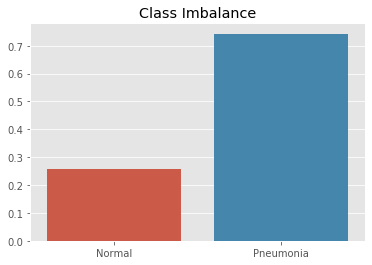

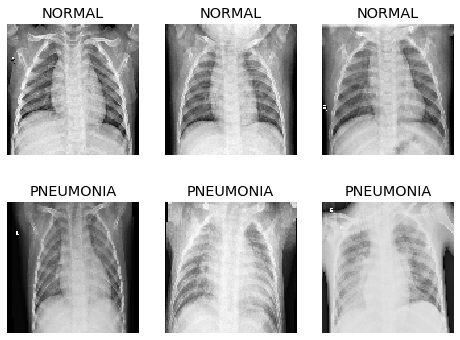

In [44]:
train_dir = './src/data/chest_xray/train/' # image folder

# get the list of jpegs from sub image class folders
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/NORMAL') if fn.endswith('.jpeg')]
pneumo_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg')]

# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)


# Visualize the class imbalance
import seaborn as sns

normal_size = len(normal_imgs)/(len(normal_imgs)+len(pneumo_imgs))
pnue_size = len(pneumo_imgs)/(len(normal_imgs)+len(pneumo_imgs))


ax = sns.barplot(x = ['Normal', 'Pneumonia'],
                 y = [normal_size, pnue_size]);
ax.set_title("Class Imbalance");


# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        fp = f'{train_dir}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

The first thing to note is that we have a class imbalance between healthy and pnuemonia patients where there are fewer healthy picture than ones with pnuemonia. In medidical imaging this is a common occurance. The people who are sicker are more likely to recieve chest x rays and therefore we would expect there to be a higher number of x rays featuring patients with pnueomonia.

The image above shows three healthy chest xrays and three chest xrays of patients with pneumonia. Patients with pnuemonia have less defined organ structures. There is generally a "haze" around the lung area. This haze is caused by a build up of fluid and scarring caused by bacterial or viral infections causing the pnuemonia.

However, this is just a small sample, in fact, the central pneuomonia image is take from the side whereas the other 5 images are taken from the anterior to posterior axis.

To see if there are differences in the in the xrays of sick versus healthy patients overall, calculated the mean value for each pixel in the image array and took the mean of those pixels.

To do this, we imported each picture seperately, adjusted their size so that they are all 224,224 and converted them to grayscale. We then flattened the two dimensional array to 1 dimension using np.ravel() and concatenated all of the vectors into one matrix call full_mat (full_matrix).

Once we had our full matrix, we took the mean accross each row (matching pixels in the image) concatenated them into an n X m matrix

In [45]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images = img2np(f'{train_dir}/NORMAL/', normal_imgs)
pnemonia_images = img2np(f'{train_dir}/PNEUMONIA/', pneumo_imgs)

In [ ]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0) 
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pnemonia_images, 'PNEUMONIA')